In [1]:
# MO444-A 2s/2017 - Third assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

# Plotting inline instead of opening an outer window.
%matplotlib inline

# Imports
import cgi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Markdown, display
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale

random_state = np.random.RandomState(1)

def printm(msg):
    """Print in notebook using markups."""
    display(Markdown(msg))

def loadIDs():
    lines=[]
    with open('documents/ids', "r") as f:
        lines = f.read().splitlines()
    return np.asarray(lines)

def loadFeatures():
    features = pd.read_csv('documents/data.csv', sep=',', header=None)
    return features.values

def loadDocument(docID):
    data = None
    with open('documents/docs/' + docID, 'r') as docfile:
        data = docfile.read()
    return data

In [2]:
ids = loadIDs()
print('IDs shape: {}'.format(ids.shape))

data = loadFeatures()
print('Data shape: {}'.format(data.shape))

IDs shape: (19924,)
Data shape: (19924, 2209)


In [3]:
# Let's look at the 5 first instances of the IDs
print(ids[0:5])

['832e15531654188fa0b951faa5f68540dfb1ca5a'
 'aa5163928a6edfd3bf69fd11fe763aacecf4602d'
 'e886703afff0c70d6598bcae0c2d69a5a237807f'
 'c1ea507b177b2e1673ce7a576057f91b75ae9d29'
 'bbf73405c85d22702fafc1c0916e8f713810ff8d']


In [4]:
# Now, let's have a look at the 5 first instances of the data (bag-of-words feature vectors)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208
0,0.077257,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.055755,0.0,0.0
2,0.042250,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.093693,0.0,0.099296,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.069105,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.036811,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.041917,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [5]:
# Checking the value ranges
print('Min. value: {}'.format(np.min(data.flatten())))
print('Max. value: {}'.format(np.max(data.flatten())))

# Let's scale and normalize the data
data = scale(data)

normalizer = Normalizer()
normalizer = normalizer.fit(data)

data = normalizer.transform(data)

Min. value: 0.0
Max. value: 0.999901


In [6]:
# Defining some auxiliary methods for running K Means
def printGraphsForMultipleCentroids(num_centroids, costs, sil_avgs, ch_scores):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col')

    ax1.set_title('cost')
    ax1.plot(num_centroids, costs)

    ax2.set_title('silhouettes')
    ax2.plot(num_centroids, sil_avgs)

    ax3.set_title('calinski harabaz score')
    ax3.plot(num_centroids, ch_scores)

    f.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
    f.set_size_inches(15, 5)
    f.show()

def computeKMeansMetrics(model, data):
    labels = model.fit_predict(data)
    cost = model.inertia_
    sil_avg = silhouette_score(data, labels)
    ch_score = calinski_harabaz_score(data, labels)
    return labels, cost, sil_avg, ch_score

def runKmeansForMultipleCentroids(data):
    models, labels, costs, sil_avgs, ch_scores = [], [], [], [], []
    num_centroids = [2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200]
    for i in num_centroids:
        model = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=random_state)
        myLabels, cost, sil_avg, ch_score = computeKMeansMetrics(model, data)
        models.append(model)
        labels.append(myLabels)
        costs.append(cost)
        sil_avgs.append(sil_avg)
        ch_scores.append(ch_score)
        print('%d clusters: Cost %5.2f; Silhouette avg %5.5f; Calinski-Harabasz Index: %5.2f' % (i, cost, sil_avg, ch_score))
    printGraphsForMultipleCentroids(num_centroids, costs, sil_avgs, ch_scores)
    return models, labels, costs, sil_avgs, ch_scores

2 clusters: Cost 19800.31; Silhouette avg 0.00620; Calinski-Harabasz Index: 123.59
4 clusters: Cost 19692.85; Silhouette avg 0.00466; Calinski-Harabasz Index: 78.31
6 clusters: Cost 19578.50; Silhouette avg 0.00645; Calinski-Harabasz Index: 71.50
8 clusters: Cost 19550.11; Silhouette avg 0.00610; Calinski-Harabasz Index: 55.12
10 clusters: Cost 19442.51; Silhouette avg 0.00792; Calinski-Harabasz Index: 55.43
15 clusters: Cost 19283.79; Silhouette avg 0.00941; Calinski-Harabasz Index: 47.84
20 clusters: Cost 19176.90; Silhouette avg 0.01001; Calinski-Harabasz Index: 41.32
25 clusters: Cost 19008.79; Silhouette avg 0.01419; Calinski-Harabasz Index: 41.02
30 clusters: Cost 18881.43; Silhouette avg 0.01461; Calinski-Harabasz Index: 38.31
35 clusters: Cost 18778.77; Silhouette avg 0.01591; Calinski-Harabasz Index: 36.54
40 clusters: Cost 18758.71; Silhouette avg 0.01557; Calinski-Harabasz Index: 32.26
45 clusters: Cost 18619.78; Silhouette avg 0.01758; Calinski-Harabasz Index: 32.22
50 clus

/Library/Python/2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


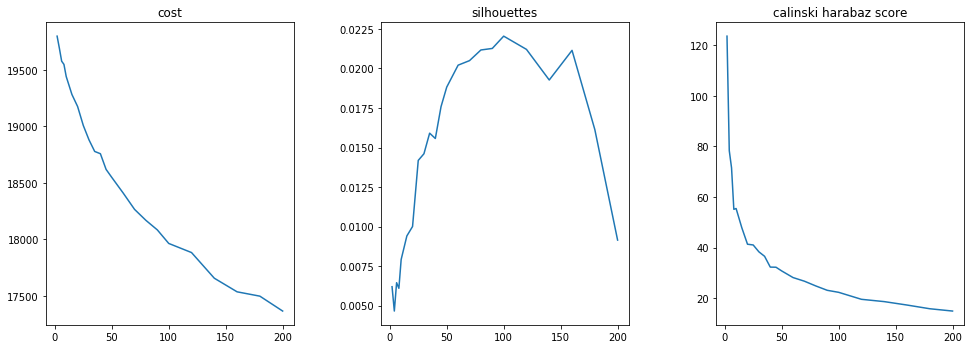

In [7]:
# Attempting Mini-Batch K means with some different number of centroids.
models, labels, costs, sil_avgs, ch_scores = runKmeansForMultipleCentroids(data)

In [8]:
##### Let's check some sample groups, their medoid documents, and two other closer documents.
def loadEscapedDoc(doc_id):
    return cgi.escape(loadDocument(doc_id).replace('$', '').replace('*', '')).replace('\n', '<br>')

def analyze_centroids(chosen_model, chosen_model_labels, data):
    tbl = ['<table><tr><th>Medoid</th><th>Closest 1</th><th>Closest 2</th></tr><tr>']
    td_style = 'style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;"'
    groups = np.random.choice(chosen_model.n_clusters, 5, replace=False)
    print('Selected groups: {}'.format(groups))
    for i in groups:
        center = chosen_model.cluster_centers_[i]
        group_points = data[chosen_model_labels == i]
        group_doc_ids = ids[chosen_model_labels == i]

        # Let's find the medoid and their closest points
        distancesMatrix = pairwise_distances(group_points, metric='euclidean')
        closest_to_medoid_indexes = np.argsort(distancesMatrix.sum(axis=0))
        medoid_index = closest_to_medoid_indexes[0]

        medoid = group_doc_ids[medoid_index]
        closest1 = group_doc_ids[closest_to_medoid_indexes[1]]
        closest2 = group_doc_ids[closest_to_medoid_indexes[2]]
        tbl.append('<td %s>**%s**<br>%s</td>'
                   '<td %s>**%s**<br>%s</td>'
                   '<td %s>**%s**<br>%s</td>' % (
            td_style, medoid, loadEscapedDoc(medoid),
            td_style, closest1, loadEscapedDoc(closest1),
            td_style, closest2, loadEscapedDoc(closest2)))

    tbl.append('</tr></table>')
    printm('</tr><tr>'.join(tbl))

In [9]:
# Chosen number of centroids
chosen_i = 16 # Meaning 90 centroids
chosen_model = models[chosen_i]
chosen_model_labels = labels[chosen_i]
print('Chosen # of centroids: {}'.format(chosen_model.n_clusters))
print('Cost:                    %18.3f' % costs[chosen_i])
print('Silhouette avg:          %18.3f' % sil_avgs[chosen_i])
print('Calinski-Harabasz Index: %18.3f' % ch_scores[chosen_i])
analyze_centroids(chosen_model, chosen_model_labels, data)

Chosen # of centroids: 90
Cost:                             18083.669
Silhouette avg:                       0.021
Calinski-Harabasz Index:             23.091
Selected groups: [10 53 49 35 32]


<table><tr><th>Medoid</th><th>Closest 1</th><th>Closest 2</th></tr><tr></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**a2015e07ca42def9ba97afe0c37139eecece8c60**<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!uwm.edu!cs.utexas.edu!uunet!cis.ohio-state.edu!bounce-bounce<br>From: fields@cis.ohio-state.edu (jonathan david fields)<br>Newsgroups: misc.forsale<br>Subject: Misc. Stuff for Sale<br>Message-ID: &lt;1po5lqINN749@penguin.cis.ohio-state.edu&gt;<br>Date: 4 Apr 93 18:31:22 GMT<br>Article-I.D.: penguin.1po5lqINN749<br>Distribution: usa<br>Organization: The Ohio State University Dept. of Computer and Info. Science<br>Lines: 46<br>NNTP-Posting-Host: penguin.cis.ohio-state.edu<br><br><br>Misc. Items for sale:<br><br><br>Walkman:  Aiwa Model HS-T30, 1 year old, mint condition, hardly used, <br>          autoreverse, 3 band Equalizer, Super Bass, Dolby Noise Reduction,<br>          AM FM tuner..........Paid 70.......Asking 40+shipping.<br><br>Mount Plate:  Sony Model CPM-203P, mounting plate for Sony portable CD players<br>for Portable: plugs into car lighter, snaps onto the bottom of any Sony<br>CD Player:    Portable CD player, perfect condition. Will also throw in a <br>	      cassette adapter in SO SO condition.<br>	      Paid 45...............Asking 30+shipping.<br><br>AM FM:	    Factory Stereo from Toyota with AM FM radio, autoreverse cassette<br>Cassette:   deck, digital tuning, like new condition only in car 6 months,<br>Car Stereo: Asking 60+shipping.<br><br>Car Speakers:	Sherwood 5 1/4" two way car speakers, in car for 7 months,<br>5 1/4 inch:	excellent condition, Paid 65............Asking 40+shipping.<br><br>4 inch:	    Factory Speakers from Toyota excellent condition <br>	    Asking 20+shipping.<br><br><br>Nintendo:   Nintendo Game Boy, Light Boy, Tetris, Super Mario Land,  <br>Gameboy:    NFL Football, Castlevania Adventure, Hyper Lode Runner, 4 years<br>+ games:    old	all in working condition, Asking 70+shipping.<br>Accessories:<br><br><br>Whole Internet:	The Whole Internet: User's Guide and Catalog by ED Krol,<br>book:		guide to using the internet, where to fing information and <br>		resources.   Paid 30..........Asking 20+shipping.<br><br>MicroSoft:    Never Used, came with my computer, Asking  60+shipping.<br>Visual Basic:<br><br>MicroSoft:  For Windows, never used, came with my computer, <br>Quick C:    Sells new Student edition for 95............Asking 70+shipping.<br><br>Please resond to fields@cis.ohio-state.edu<br><br>				Thanks,<br><br>				Jonathan D. Fields<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**1dd964f8a23ee711a63405953a929f4826e95745**<br>Xref: cantaloupe.srv.cs.cmu.edu misc.forsale.computers.other:5403 misc.forsale.computers.pc-clone:8391 misc.forsale:76505<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!europa.eng.gtefsd.com!emory!news-feed-1.peachnet.edu!umn.edu!csus.edu!netcom.com!netcomsv!wet!pk<br>From: pk@wet.UUCP (Philip King)<br>Newsgroups: ba.market.computers,ba.market.misc,ca.wanted,misc.forsale.computers.other,misc.forsale.computers.pc-clone,misc.forsale<br>Subject: PC, NETWORK and OFFICE EQUIPMENT - LONG (Repost, Lower Prices!)<br>Keywords: PC,LAN,Novell,ethernet,IBM,laser,copier<br>Message-ID: &lt;5529@wet.UUCP&gt;<br>Date: 17 Apr 93 03:47:03 GMT<br>Followup-To: poster<br>Distribution: na<br>Organization: Wetware Diversions, San Francisco<br>Lines: 161<br><br><br>NEW POSTING, LOWER PRICES!!  MAKE OFFERS ON ANYTHING THAT SEEMS INTERESTING!!<br><br><br><br>A company I'm associated with is closing out some inventory and office<br>equipment.  Here's what's available:<br><br><br>Quan.          Item                     Description               Price ea.<br><br><br>         NEW ADDITIONS!! <br><br>1             NOVELL               100 USER  version of         BEST OFFER<br>              NETWARE 2.15        ADVANCED NETWARE 286, with<br>              TTS, SFT II         System Fault Tolerance level    (Remember<br>                                  II (Disk Duplexing, Mirroring),  v2.2 sells<br>                                  Transaction Tracking (Fault      for 3000<br>                                  Tolerant File System), etc.      for 100<br>                                  Just the manuals alone take      users!<br>                                  up a foot and a half of shelf<br>                                  space!<br><br>1             HAYES LANSTEP       HAYES Peer-to-Peer LAN            40<br>              Starter Package     OPERATING SYSTEM and email.<br>                                  NetBIOS compatible, expands<br>                                  up to 128 users. UNOPENED.<br><br>1             Canon NP1010        Great little COPY MACHINE -       200<br>                                  makes great copies (just needs<br>                                  toner)  Reduce, Enlarge, etc.<br>                                  Very Good Condition, a bargain!<br> <br>(End of new items)<br><br>2       Bytex RingOut             Token Ring Cable and MAU     (Was 750)<br>                                  testing and certification<br>                                  tool.  This is the standard  NOW: 625<br>                                  HANDHELD TESTING UNIT used<br>                                  by large companies such as<br>                                  Coca Cola and American Express<br>                                  to certify their physical layer.<br>                                  Current retail price: 1495.<br>                                  These are demo or NEW.<br><br>1       Microtest Lanmodem        Excellent MODEM SERVER for Novell (Was<br>                                  Networks.  Supports "Remote LAN    900)<br>                                  Node" indial, modem pooling, and<br>                                  LAN to LAN asynchronous routing.   NOW:<br>                                  Ethernet version.  Current retail  750<br>                                  price: 2000<br><br>13      Microtest Lanport         Standalone ETHERNET PRINT    WAS: 200<br>        AUI --&gt; COM1              SERVER for Novell Networks<br>                                  (The Intel NetportII is      NOW: 150 ea.<br>                                  based on this.  Original<br>                                  retail: 595)  Most of<br>                                  these are BRAND NEW.<br><br>12      Microtest Lanport         See above                           "<br>        BNC --&gt; COM1<br><br>11      Microtest Lanport         See above                           "<br>        BNC --&gt; COM1, COM2<br><br>3       Microtest Lanport         See above                           "<br>        AUI --&gt; COM1, COM2<br><br>4       Microtest Lanport         See above                           "<br>        AUI --&gt; LPT1<br><br>1       Microtest Lanport         See above                           "<br>        BNC --&gt; LPT1<br><br><br>2       Token Ring MAU            8-port IBM 8228 clone             100<br><br>5       Milan MIL-03P             AUI to 10BaseT Mini TRANSCEIVER (WAS: 50)<br>                                                                   NOW: 40<br><br>1       QMS SmartWriter 8/3X      HP LaserJet PLUS Compatible    (WAS 400)<br>                                  LASER PRINTER.  8 ppm, 300 dpi.<br>                                  Based on the Canon Engine, it   NOW: 325<br>                                  has serial and IBM TWINAX ports.<br>                                  Emulates HP, Epson FX, IBM<br>                                  Proprinter, Diablo, and Qume.<br>                                  Downloads HP fonts.  Reliable!<br><br>2       IBM Quietwriter 2         Quiet, letter-quality PRINTER.    100<br>                                  1 sheet at a time feed.  Have<br>                                  extra ribbon cartridges.<br><br>1       IBM Tractor Feed          For the Quietwriter above.        25<br><br>3       IBM PC/XT Compatible      Misc PC/XT compatible COMPUTERS,  (WAS:<br>                                  some are "PCs Limited" (original  150)<br>                                  DELL Computer Co.), some are<br>                                  "Tech PC/XT".  These come with    NOW:<br>                                  at least a 20 MB hard disk, a     125<br>                                  360 KB floppy, monochrome video<br>                                  card, keyboard, and 640 kb of<br>                                  memory.<br><br>3       IBM PC/AT or Compatible   Some of these are original IBM (WAS: 200-<br>                                  AT's, some are TURBO clones.         250)<br>                                  Clone brands include Tandon,<br>                                  Acer, and Everex.  Standard     NOW: 175-<br>                                  equipment is the same as above,      200<br>                                  except most have 30-40 MB hard<br>                                  drives, and 1 1.2 MB floppy.<br><br>4       Amber Monitor for PC      IBM Compatible Monochrome TTL     20<br>                                  type, brands vary, including<br>                                  Samsung, Magnavox, and ADI.<br>                                  (Mostly want to stay local on<br>                                  these - too hard to ship)<br><br>2       IBM 5151 Green Monitor    Ubiquitous IBM PC Display,        20<br>                                  Monochrome TTL type.<br>                                  (Local - see above)<br><br>1       Zenith ZFL181-92          LAPTOP PC. Full-Size and Full-  (WAS 300)<br>                                  Travel keyboard, XT compatible,<br>                                  Backlit Supertwist (?) Display,  NOW: 250<br>                                  Dual 720k floppies.<br><br>1       Accton EtherCoax-8W       8-bit, BNC ETHERNET INTERFACE   (WAS: 60)<br>                                  card for PC compatibles.  This<br>                                  unit is nicely made (mostly      NOW: 45<br>        (Also have 1 used, BO)    surface mount) clone of the<br>                                  ubiquitous Western Digital<br>                                  WD-8003E.  NEW in box with disk.<br><br>6       Western Digital WD8003E   The "real McCoy" version of the   50<br>                                  above.  Drivers are available<br>                                  for just about anything.  Used.<br>                                  Surprising performance for an 8<br>                                  bit card.  No DMA hassles.<br><br>1       Hedaka 2400 Modem         Internal, for PC Compatibles.  (WAS: 35)<br>                                  In box, almost new, works fine.<br>                                                                  NOW: 25<br><br>1       Hayes 1200B Internal      Internal 1200 real HAYES modem    15<br>                                  for PC compatibles.  Untested.<br><br><br><br>Terms on the above are C.O.D., shipping extra.  As usual, offers are welcome,<br>but I think most of these prices are more than fair.  Most of this equipment<br>is tested and working perfectly, unless otherwise noted.<br><br>Please contact me via email as follows:<br><br>pk@wet.com  {netcom,hoptoad}!wet!pk<br><br><br><br><br>Thanks!<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**25ca6b771c7d56ba168091e4b0de2483d430d191**<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!oracle!unrepliable!bounce<br>Newsgroups: misc.forsale<br>From: jpau@oracle.com<br>Subject: &gt;&gt; Misc. Car audio forsale &lt;&lt;<br>Message-ID: &lt;1993Apr26.231916.908@oracle.us.oracle.com&gt;<br>Sender: jpau@oracle.com (Jeffrey Pau)<br>Nntp-Posting-Host: dvlseq.us.oracle.com<br>Organization: Oracle Corp., Redwood Shores CA<br>Date: Mon, 26 Apr 1993 23:19:16 GMT<br>X-Disclaimer: This message was written by an unauthenticated user<br>              at Oracle Corporation.  The opinions expressed are those<br>              of the user and not necessarily those of Oracle.<br>Lines: 89<br><br>o Denon DCR 5490 (high power pull out cassette deck with CD changer control)<br><br>  Features:<br><br>  - 18 W X 4<br>  - Theft Prevention Chassis (pull out)<br>  - 24 station-presets (18 FM, 6 AM)<br>  - Denon Optimum Reception System IV (FM circuitry-Auto high blend and FM<br>    pulse noise cancellor)<br>  - Dolby B NR<br>  - Key off head release<br>  - Flexible fader-internal front amp to rear amp and/or internal front amp<br>    to internal rear amp<br>  - Auto reverse cassette mechanism<br>  - Up/down manual &amp; seek tuning<br>  - Music sensor<br>  - Stereo/Mono (FM), local switches<br>  - Metal tape switch<br>  - DIN "E" with easy installation lock-in sleeve<br>  - Night illumination with dash light dimmer lead<br>  - Preset scan<br>  - CD changer control<br>        Random play: all of tracks on a disc<br>        Automatic/Manual search<br><br>  Excellent condition with Manual.<br><br>  Asking 220.00 + shipping<br><br>o Yamaha YPA-300 power amplifier (car audio)<br>  Features:<br>        - SELECTABLE 2-MODE POWER OUTPUT:<br>          40W x 2-ch or 90W x 1-ch - all w/ extremely low distortion (0.1% THD)<br>        - LOW RFI CIRCUIT effectively eliminates radio frequency interference<br>          which might arise from DC-DC conversion<br>        - FULL PROTECTION CIRCUITRY protects amplifier from potential damaged<br>          caused by overload, short circuiting, DC leakage, excessive heat<br>          or mis-wiring.<br>        - INPUT LEVEL ADJUSTMENT allows you to complement your system with any<br>          audio component<br>        - GOLD-PLATED RCA JACK ensures a durable, optimum contact, even under<br>          rugged road conditions.<br>        - REMOTE POWER links the entire system's ON/OFF with the cassette<br>          receiver's ot tuner's power switch.<br>        - SCREW TERMINALS allow simple wiring connections<br>        - POWER FUSE REPLACEMENT is a simple, one-step operation.<br>        - ALTERNATER NOISE REDUCTION CIRCUITRY is effectively suppressed<br>          during driving.<br>  Specifications:<br>    Continuous Power Output<br>          (per channel, 4 ohms, 2 channels driven.)<br>          with 0.1 % THD, 20 Hz ~ 20kHz .................35W/35W<br>          with 0.1 % THD, 1 kHz .........................40W/40W<br>          (per channel, 4 ohms, 1 channels driven.)<br>          with 0.1 % THD, 20 Hz ~ 20kHz ................80W(BTL)<br>          with 0.1 % THD, 1 kHz ........................90W(BTL)<br>    Speaker Impedance................................4 to 8 ohms<br>    Frequency Response (at 1W, 4 ohms)......10 Hz to 100 kHz (+0, -1.5dB)<br>    Signals-to-Noise Ratio ...............................105 dB<br>    Total Harmonic Distortion<br>        - (at 20W + 20W, 1 kHz, 4 ohms, 24 kHz, LPF)......0.005%<br>    Dimensions (W x H x D).....................200 x 50 x 156 mm<br>    Weight..........................................5 lbs. 15 oz<br><br>    List price: 250.00<br><br>    This is one of the nicest/cleanest amp that I have even owned.<br>    I am using two of these in my car, this is just an extra one that<br>    I don't really need.  If you are in the bay area, and like to listen<br>    to it first, let me know.<br><br>    Asking 150.00 firm + shipping (brand new in box, never been installed)<br><br><br>o Boston Acoustic 861 seperates (car audio speakers), 6" woofers<br>  with seperate tweeters and crossovers.<br>  Brand new in box, never been installed, 259.00 at Good Guys<br>  Asking 199.00 firm<br><br>o 2 8" MTX free air woofers, new in box, never been installed.<br>  Paid 49.00 each at Good Guys<br>  Asking 70.00 firm<br><br>o UNGO Box top of the line 5400 auto alarm with 2 twin-buttons remote<br>  (patented electronic motion/shock sensor, parking light flasher, ignition<br>  kill, panic mode, power door lock/unlocking control, LED flashing status<br>  light, arms all doors, hood and trunk, etc.)<br>  News in box, 180.00 firm<br><br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**61b8034caa3dc22951ce86946e92e5c3f48ca3f8**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.religion.misc:83667 talk.politics.guns:54325 soc.culture.jewish:63110<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!darwin.sura.net!spool.mu.edu!uwm.edu!caen!msuinfo!maple.egr.msu.edu!friedenb<br>From: friedenb@maple.egr.msu.edu (Gedaliah Friedenberg)<br>Newsgroups: talk.religion.misc,talk.politics.guns,soc.culture.jewish<br>Subject: Re: Who's next?  Mormons and Jews?<br>Followup-To: talk.religion.misc<br>Date: 20 Apr 1993 00:48:23 GMT<br>Organization: College of Engineering, Michigan State University<br>Lines: 42<br>Distribution: world<br>Message-ID: &lt;1qvh8ngf4@msuinfo.cl.msu.edu&gt;<br>References: &lt;1qvfik6rf@usenet.INS.CWRU.Edu&gt;<br>Reply-To: friedenb@maple.egr.msu.edu (Gedaliah Friedenberg)<br>NNTP-Posting-Host: maple.egr.msu.edu<br><br>In article &lt;1qvfik6rf@usenet.INS.CWRU.Edu&gt;, cj195@cleveland.Freenet.Edu (John W. Redelfs) writes:<br>|&gt; <br>|&gt; Now that Big Brother has rubbed out one minority religion in Waco, who is<br>|&gt; next?  The Mormons or Jews?<br><br>Give me a break.  If the Mormons fortified Utah and armed it to the teeth,<br>and were involved in illegal activity, then they deserve whatever they get.<br><br>You are making a ludicrous suggestion.<br><br>|&gt; We used to live in a country where everyone enjoyed the free exercise of<br>|&gt; their rights to worship and bear arms.  Now we don't.<br><br>Does that include the right to murder little children?  How about killing<br>ATF officers?  I do not know much about the gun laws in Texas, but <br>Koresh's folks claimed to have grenades, grenade launchers, and rocket<br>launchers.  I am not sure that the NRA feels that this falls under <br>"right to bear arms."<br> <br>|&gt; Of course, to Jews and Mormons this is just a broken record.  It has<br>|&gt; happened before.<br><br>Please explain.  I do not remember Jews or Mormons (as a group) overtly <br>breaking a judicious (a.k.a. non-Nazi) law and being punished for it.<br> <br>|&gt; I'll bet all you cult haters are happy now, right?  Just hope you're not next.<br><br>Followups to /dev/null  <br><br>Alternative followups set to talk.religion.misc<br><br> <br>|&gt; ------------ John W. Redelfs, cj195@cleveland.freenet.edu -------------<br>|&gt; --------- All my opinions are tentative pending further data. ---------<br> <br>Gedaliah Friedenberg<br>-=-Department of Mechanical Engineering<br>-=-Department of Metallurgy, Mechanics and Materials Science<br>-=-Michigan State University<br><br><br>                   <br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**61b8034caa3dc22951ce86946e92e5c3f48ca3f8**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.religion.misc:83667 talk.politics.guns:54325 soc.culture.jewish:63110<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!darwin.sura.net!spool.mu.edu!uwm.edu!caen!msuinfo!maple.egr.msu.edu!friedenb<br>From: friedenb@maple.egr.msu.edu (Gedaliah Friedenberg)<br>Newsgroups: talk.religion.misc,talk.politics.guns,soc.culture.jewish<br>Subject: Re: Who's next?  Mormons and Jews?<br>Followup-To: talk.religion.misc<br>Date: 20 Apr 1993 00:48:23 GMT<br>Organization: College of Engineering, Michigan State University<br>Lines: 42<br>Distribution: world<br>Message-ID: &lt;1qvh8ngf4@msuinfo.cl.msu.edu&gt;<br>References: &lt;1qvfik6rf@usenet.INS.CWRU.Edu&gt;<br>Reply-To: friedenb@maple.egr.msu.edu (Gedaliah Friedenberg)<br>NNTP-Posting-Host: maple.egr.msu.edu<br><br>In article &lt;1qvfik6rf@usenet.INS.CWRU.Edu&gt;, cj195@cleveland.Freenet.Edu (John W. Redelfs) writes:<br>|&gt; <br>|&gt; Now that Big Brother has rubbed out one minority religion in Waco, who is<br>|&gt; next?  The Mormons or Jews?<br><br>Give me a break.  If the Mormons fortified Utah and armed it to the teeth,<br>and were involved in illegal activity, then they deserve whatever they get.<br><br>You are making a ludicrous suggestion.<br><br>|&gt; We used to live in a country where everyone enjoyed the free exercise of<br>|&gt; their rights to worship and bear arms.  Now we don't.<br><br>Does that include the right to murder little children?  How about killing<br>ATF officers?  I do not know much about the gun laws in Texas, but <br>Koresh's folks claimed to have grenades, grenade launchers, and rocket<br>launchers.  I am not sure that the NRA feels that this falls under <br>"right to bear arms."<br> <br>|&gt; Of course, to Jews and Mormons this is just a broken record.  It has<br>|&gt; happened before.<br><br>Please explain.  I do not remember Jews or Mormons (as a group) overtly <br>breaking a judicious (a.k.a. non-Nazi) law and being punished for it.<br> <br>|&gt; I'll bet all you cult haters are happy now, right?  Just hope you're not next.<br><br>Followups to /dev/null  <br><br>Alternative followups set to talk.religion.misc<br><br> <br>|&gt; ------------ John W. Redelfs, cj195@cleveland.freenet.edu -------------<br>|&gt; --------- All my opinions are tentative pending further data. ---------<br> <br>Gedaliah Friedenberg<br>-=-Department of Mechanical Engineering<br>-=-Department of Metallurgy, Mechanics and Materials Science<br>-=-Michigan State University<br><br><br>                   <br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**719ee182ed3233c1406a8f407b06c23e74b048e5**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.religion.misc:83859 talk.politics.guns:54536 soc.culture.jewish:63265<br>Newsgroups: talk.religion.misc,talk.politics.guns,soc.culture.jewish<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!sdd.hp.com!network.ucsd.edu!pacbell.com!amdahl!netcomsv!netcom.com!solovay<br>From: solovay@netcom.com (Andrew Solovay)<br>Subject: Re: Who's next?  Mormons and Jews?<br>Message-ID: &lt;solovayC5rKCn.5J9@netcom.com&gt;<br>Summary: Jews, of course.<br>Organization: 100 Aker Wood<br>References: &lt;1qvfik6rf@usenet.INS.CWRU.Edu&gt;<br>Date: Tue, 20 Apr 1993 03:57:59 GMT<br>Lines: 20<br><br>In article &lt;1qvfik6rf@usenet.INS.CWRU.Edu&gt; cj195@cleveland.Freenet.Edu (John W. Redelfs) writes:<br>&gt;<br>&gt;Now that Big Brother has rubbed out one minority religion in Waco, who is<br>&gt;next?  The Mormons or Jews?<br>&gt;<br>&gt;[...]<br>&gt;<br>&gt;Of course, to Jews and Mormons this is just a broken record.  It has<br>&gt;happened before.<br><br>It's only been happening to the Mormons for... what? 150 years?<br>Pikers. We've been persecuted for well over 3000 years. The Mormons<br>just aren't in our league.<br><br>(Am I the only one who's reminded of Masada?)<br>-- <br>Andrew M. Solovay    <br><br>"I have been Foolish and Deluded, <br> and I am a Bear of No Brain at All."     -- Pooh<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**c7212fea91de40a0158a1d71a892141dd7010a0b**<br>Newsgroups: rec.sport.baseball<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!pacific.mps.ohio-state.edu!linac!att!att-out!cbfsb!cbnewsg.cb.att.com!sas<br>From: sas@cbnewsg.cb.att.com (s.a.sullivan)<br>Subject: Re: Let's play the name game!<br>Message-ID: &lt;C5sDx7.Gzx@cbfsb.cb.att.com&gt;<br>Sender: news@cbfsb.cb.att.com<br>Organization: AT&amp;T<br>References: &lt;1993Apr20.035607.26095@newshub.ariel.yorku.ca&gt;<br>Distribution: na<br>Date: Tue, 20 Apr 1993 14:36:42 GMT<br>Lines: 13<br><br>In article &lt;1993Apr20.035607.26095@newshub.ariel.yorku.ca&gt; cs902043@ariel.yorku.ca (SHAWN LUDDINGTON) writes:<br>&gt;How about changing team names!<br>&gt;Post your choices!<br>&gt;<br>&gt;Here I'll start:<br>&gt;How about the <br>&gt;Baltimore Baseblazers<br>&gt;San Francisco Quakes<br>&gt;Pittsburgh Sellouts&gt;<br>&gt;Shawn - Go Rangers!!!!!!!!!!!!!!!!!!!<br>&gt;<br><br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**55a02e26ad2c7fdfd54fb5430f57d3597c47c2c0**<br>Newsgroups: rec.motorcycles<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!news.crd.ge.com!uunet!zaphod.mps.ohio-state.edu!uwm.edu!linac!att!att-out!cbfsb!cbnewsg.cb.att.com!jjd1<br>From: jjd1@cbnewsg.cb.att.com (james.j.dutton)<br>Subject: Re: Twit Bicyclists (was RE: Oh JOY!)<br>Message-ID: &lt;1993Apr5.195058.1465@cbfsb.cb.att.com&gt;<br>Sender: news@cbfsb.cb.att.com<br>Organization: AT&amp;T<br>References: &lt;93Apr01.180927.33048@acs.ucalgary.ca&gt; &lt;1993Apr2.045903.6066@spectrum.xerox.com&gt;<br>Distribution: na<br>Date: Mon, 5 Apr 1993 19:50:58 GMT<br>Lines: 20<br><br>In article &lt;1993Apr2.045903.6066@spectrum.xerox.com&gt; cooley@xerox.com writes:<br>&gt;Yo, ASSHOLES.  I hope you are all just kidding<br>&gt;because it's exactly that kind of attidue that gets<br>&gt;many a MOTORcyclist killed:  "Look at the leather<br>&gt;clad poseurs!  Watch how they swirve and<br>&gt;swear as I pretend that they don't exist while<br>&gt;I change lanes."<br>&gt;<br>&gt;If you really find it necesary to wreck others<br>&gt;enjoyment of the road to boost your ego, then<br>&gt;it is truely you who are the poseur.<br>&gt;<br>&gt;--aaron<br><br>Disgruntled Volvo drivers. What are they rebelling against?<br> <br>================================================================================<br> Steatopygias's 'R' Us.          doh#0000000005 That ain't no Hottentot.<br> Sesquipedalian's 'R' Us. ZX-10. AMA#669373 DoD#564. There ain't no more.<br>================================================================================<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**ce14a4a8554a828d0e14e4dea2df7e43f405f6fc**<br>Xref: cantaloupe.srv.cs.cmu.edu misc.forsale:76252 misc.fitness:17444<br>Newsgroups: misc.forsale,misc.fitness<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!bogus.sura.net!news-feed-1.peachnet.edu!emory!swrinde!zaphod.mps.ohio-state.edu!pacific.mps.ohio-state.edu!linac!att!att-out!cbfsb!cbnewsf.cb.att.com!garla<br>From: garla@cbnewsf.cb.att.com (padma.garla)<br>Subject: 4SALE, BALLY's JACK LALLANE MEMBERSHIP<br>Message-ID: &lt;C5y4FA.6M4@cbfsb.cb.att.com&gt;<br>Followup-To: poster<br>Keywords: GOLD MEMBERSHIP, NEGOTIABLE PRICE<br>Sender: news@cbfsb.cb.att.com<br>Organization: AT&amp;T<br>Distribution: usa<br>Date: Fri, 23 Apr 1993 16:57:09 GMT<br>Lines: 6<br><br>Two Jack LaLlane GOLD memberships are for sale by the owners.<br>Asking for 600 for each membership. <br><br>Please contact Padma &amp; Srini at (908) 855-8865 for details.<br><br>Thanks<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**c1130e21c7008cb351ef34b3563710cdfe9d684e**<br>Newsgroups: misc.forsale<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!gatech!darwin.sura.net!haven.umd.edu!uunet!mnemosyne.cs.du.edu!nyx!ibeshir<br>From: ibeshir@nyx.cs.du.edu (Ibrahim)<br>Subject: Terminal forsale<br>Message-ID: &lt;1993Apr17.235223.24725@mnemosyne.cs.du.edu&gt;<br>Sender: usenet@mnemosyne.cs.du.edu (netnews admin account)<br>Organization: Nyx, Public Access Unix @ U. of Denver Math/CS dept.<br>Date: Sat, 17 Apr 93 23:52:23 GMT<br>Lines: 1<br><br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**0bb1ce80ebb47ebb04077a570b9d42bcace1e319**<br>Newsgroups: comp.os.ms-windows.misc<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!mnemosyne.cs.du.edu!nyx!bwise<br>From: bwise@nyx.cs.du.edu (Brandon Wise)<br>Subject: Anyone heard of _DELTREE_?<br>Message-ID: &lt;1993May17.024128.13355@mnemosyne.cs.du.edu&gt;<br>Sender: usenet@mnemosyne.cs.du.edu (netnews admin account)<br>Organization: Nyx, Public Access Unix @ U. of Denver Math/CS dept.<br>	Some poor MS Windows user was on here whining about having to<br>Distribution: na<br>Date: Mon, 17 May 93 02:41:28 GMT<br>Lines: 4<br><br>Brandon Wise<br>bwise@nyx.cs.du.edu<br><br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**a786fda00954eb0610ef4cd397d073439b2c4a80**<br>Newsgroups: misc.forsale<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!zaphod.mps.ohio-state.edu!darwin.sura.net!haven.umd.edu!uunet!mnemosyne.cs.du.edu!nyx!ibeshir<br>From: ibeshir@nyx.cs.du.edu (Ibrahim)<br>Subject: Terminal for sale<br>Message-ID: &lt;1993Apr17.235525.24921@mnemosyne.cs.du.edu&gt;<br>Sender: usenet@mnemosyne.cs.du.edu (netnews admin account)<br>Organization: Nyx, Public Access Unix @ U. of Denver Math/CS dept.<br>Distribution: usa<br>Date: Sat, 17 Apr 93 23:55:25 GMT<br>Lines: 5<br><br>I have a vt200 and vt100 compatible terminal<br>with 1200 external hyess modem<br>amber screens 101 keyboard,cable<br>make an offer<br>0<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**c319a19a915f3243f97d0f50ede72b6446cc952c**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:120371 talk.religion.misc:83465 talk.politics.misc:178330<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!pacific.mps.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!agate!dzkriz<br>From: dzkriz@ocf.berkeley.edu (Dennis Kriz)<br>Newsgroups: talk.abortion,talk.religion.misc,talk.politics.misc<br>Subject: Re: ABORTION and private health coverage -- letters regarding<br>Followup-To: talk.abortion,talk.politics.misc,talk.religion.misc<br>Date: 15 Apr 1993 14:58:46 GMT<br>Organization: U. C. Berkeley Open Computing Facility<br>Lines: 29<br>Message-ID: &lt;1qjt76ll@agate.berkeley.edu&gt;<br>References: &lt;1qid8sik0@agate.berkeley.edu&gt; &lt;C5IDKn.MMt@watson.ibm.com&gt;<br>NNTP-Posting-Host: lightning.berkeley.edu<br><br>In article &lt;C5IDKn.MMt@watson.ibm.com&gt; margoli@watson.IBM.com (Larry Margolis) writes:<br>&gt;In &lt;1qid8sik0@agate.berkeley.edu&gt; dzkriz@ocf.berkeley.edu (Dennis Kriz) writes:<br>|&gt;&gt;I recently have become aware that my health insurance includes<br>|&gt;&gt;coverage for abortion.  I strongly oppose abortion for reasons of<br>|&gt;&gt;conscience.  It disturbs me deeply to know that my premiums may<br>|&gt;&gt;be being used to pay for that which I sincerely believe is<br>|&gt;&gt;murder.  I would like to request that I be exempted from abortion<br>|&gt;&gt;coverage with my health premiums reduced accordingly.<br>|&gt;&gt;<br>&gt;Reduced?  Abortion is a lot cheaper than pre-natal care and birth.<br>&gt;If you wanted to pay the higher premiums that would result if everyone<br>&gt;using their health insurance to pay for an abortion instead elected to<br>&gt;carry to term, I'm pretty sure that your insurance carrier would be<br>&gt;happy to take your money.<br>&gt;--<br>&gt;Larry Margolis, MARGOLI@YKTVMV (Bitnet), margoli@watson.IBM.com (Internet)<br><br>Larry,<br><br>One pays insurance to pay for coverage one expects/fears one might need.<br>If one is opposed to abortion, one should not be required to pay for<br>"coverage" of it because one will NEVER want to use that "service" and<br>neither should that person be COMPELLED to pay for other people's<br>abortions PARTICULARLY if one sincerely believes that abortion is<br>murder.  <br><br>dennis<br>dzkriz@ocf.berkeley.edu<br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**c319a19a915f3243f97d0f50ede72b6446cc952c**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:120371 talk.religion.misc:83465 talk.politics.misc:178330<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!pacific.mps.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!agate!dzkriz<br>From: dzkriz@ocf.berkeley.edu (Dennis Kriz)<br>Newsgroups: talk.abortion,talk.religion.misc,talk.politics.misc<br>Subject: Re: ABORTION and private health coverage -- letters regarding<br>Followup-To: talk.abortion,talk.politics.misc,talk.religion.misc<br>Date: 15 Apr 1993 14:58:46 GMT<br>Organization: U. C. Berkeley Open Computing Facility<br>Lines: 29<br>Message-ID: &lt;1qjt76ll@agate.berkeley.edu&gt;<br>References: &lt;1qid8sik0@agate.berkeley.edu&gt; &lt;C5IDKn.MMt@watson.ibm.com&gt;<br>NNTP-Posting-Host: lightning.berkeley.edu<br><br>In article &lt;C5IDKn.MMt@watson.ibm.com&gt; margoli@watson.IBM.com (Larry Margolis) writes:<br>&gt;In &lt;1qid8sik0@agate.berkeley.edu&gt; dzkriz@ocf.berkeley.edu (Dennis Kriz) writes:<br>|&gt;&gt;I recently have become aware that my health insurance includes<br>|&gt;&gt;coverage for abortion.  I strongly oppose abortion for reasons of<br>|&gt;&gt;conscience.  It disturbs me deeply to know that my premiums may<br>|&gt;&gt;be being used to pay for that which I sincerely believe is<br>|&gt;&gt;murder.  I would like to request that I be exempted from abortion<br>|&gt;&gt;coverage with my health premiums reduced accordingly.<br>|&gt;&gt;<br>&gt;Reduced?  Abortion is a lot cheaper than pre-natal care and birth.<br>&gt;If you wanted to pay the higher premiums that would result if everyone<br>&gt;using their health insurance to pay for an abortion instead elected to<br>&gt;carry to term, I'm pretty sure that your insurance carrier would be<br>&gt;happy to take your money.<br>&gt;--<br>&gt;Larry Margolis, MARGOLI@YKTVMV (Bitnet), margoli@watson.IBM.com (Internet)<br><br>Larry,<br><br>One pays insurance to pay for coverage one expects/fears one might need.<br>If one is opposed to abortion, one should not be required to pay for<br>"coverage" of it because one will NEVER want to use that "service" and<br>neither should that person be COMPELLED to pay for other people's<br>abortions PARTICULARLY if one sincerely believes that abortion is<br>murder.  <br><br>dennis<br>dzkriz@ocf.berkeley.edu<br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**8cf3601f9bf1004245249d204d2b9186d9bf5885**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.abortion:120587 talk.politics.misc:178527 talk.religion.misc:83588<br>Newsgroups: talk.abortion,talk.politics.misc,talk.religion.misc<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!uwm.edu!linac!uchinews!raistlin!timbuk.cray.com!hemlock.cray.com!mon<br>From: mon@cray.com (Muriel Nelson)<br>Subject: Re: ABORTION and private health coverage -- letters regarding<br>Message-ID: &lt;1993Apr15.154053.3087@hemlock.cray.com&gt;<br>Lines: 35<br>Nntp-Posting-Host: hemlock<br>References: &lt;1qid8sik0@agate.berkeley.edu&gt; &lt;C5IDKn.MMt@watson.ibm.com&gt; &lt;1qjt76ll@agate.berkeley.edu&gt;<br>Date: 15 Apr 93 15:40:53 CDT<br><br>In article &lt;1qjt76ll@agate.berkeley.edu&gt; dzkriz@ocf.berkeley.edu (Dennis Kriz) writes:<br>&gt;In article &lt;C5IDKn.MMt@watson.ibm.com&gt; margoli@watson.IBM.com (Larry Margolis) writes:<br>&gt;&gt;In &lt;1qid8sik0@agate.berkeley.edu&gt; dzkriz@ocf.berkeley.edu (Dennis Kriz) writes:<br>&gt;|&gt;&gt;I recently have become aware that my health insurance includes<br>&gt;|&gt;&gt;coverage for abortion.  I strongly oppose abortion for reasons of<br>&gt;|&gt;&gt;conscience.  It disturbs me deeply to know that my premiums may<br>&gt;|&gt;&gt;be being used to pay for that which I sincerely believe is<br>&gt;|&gt;&gt;murder.  I would like to request that I be exempted from abortion<br>&gt;|&gt;&gt;coverage with my health premiums reduced accordingly.<br>&gt;|&gt;&gt;<br>&gt;&gt;Reduced?  Abortion is a lot cheaper than pre-natal care and birth.<br>&gt;&gt;If you wanted to pay the higher premiums that would result if everyone<br>&gt;&gt;using their health insurance to pay for an abortion instead elected to<br>&gt;&gt;carry to term, I'm pretty sure that your insurance carrier would be<br>&gt;&gt;happy to take your money.<br>&gt;&gt;--<br>&gt;&gt;Larry Margolis, MARGOLI@YKTVMV (Bitnet), margoli@watson.IBM.com (Internet)<br>&gt;Larry,<br>&gt;One pays insurance to pay for coverage one expects/fears one might need.<br>&gt;If one is opposed to abortion, one should not be required to pay for<br>&gt;"coverage" of it because one will NEVER want to use that "service" and<br>&gt;neither should that person be COMPELLED to pay for other people's<br>&gt;abortions PARTICULARLY if one sincerely believes that abortion is<br>&gt;murder.  <br>&gt;<br>Does someone _force_ you to carry health insurance?<br>I will NEVER want to use my insurance to pay for<br>prostate surgery either, do you think I should be<br>COMPELLED to pay for other people's glandular problems<br>when I ain't got one?<br><br>muriel<br>standard disclaimer<br><br><br></td></tr><tr></tr></table>

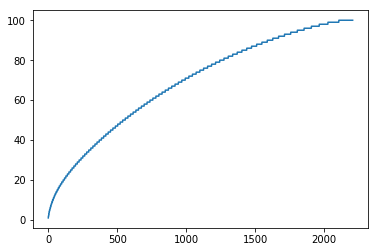

In [10]:
# Running PCA in this dataset.
pca = PCA().fit(data)

cum_variance = np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
plt.plot(cum_variance)
plt.show()

In [11]:
# Selecting the best number of components.
n_components = np.argmax(cum_variance > 70) + 1
print("Selected n_components: {}".format(n_components))

# Transforming the data.
transformed_data = PCA(n_components).fit_transform(data)
print("New transformed data shape: {}".format(transformed_data.shape))

Selected n_components: 995
New transformed data shape: (19924, 995)


2 clusters: Cost 13733.41; Silhouette avg 0.00938; Calinski-Harabasz Index: 172.37
4 clusters: Cost 13598.85; Silhouette avg 0.00632; Calinski-Harabasz Index: 124.84
6 clusters: Cost 13556.78; Silhouette avg 0.00607; Calinski-Harabasz Index: 88.06
8 clusters: Cost 13396.12; Silhouette avg 0.00847; Calinski-Harabasz Index: 97.41
10 clusters: Cost 13391.03; Silhouette avg 0.00497; Calinski-Harabasz Index: 78.38
15 clusters: Cost 13243.02; Silhouette avg 0.01176; Calinski-Harabasz Index: 67.18
20 clusters: Cost 13119.86; Silhouette avg 0.01054; Calinski-Harabasz Index: 58.95
25 clusters: Cost 12982.43; Silhouette avg 0.01902; Calinski-Harabasz Index: 56.20
30 clusters: Cost 12876.59; Silhouette avg 0.01875; Calinski-Harabasz Index: 52.77
35 clusters: Cost 12807.52; Silhouette avg 0.00039; Calinski-Harabasz Index: 48.38
40 clusters: Cost 12693.42; Silhouette avg 0.01892; Calinski-Harabasz Index: 47.37
45 clusters: Cost 12567.80; Silhouette avg 0.02299; Calinski-Harabasz Index: 46.52
50 clu

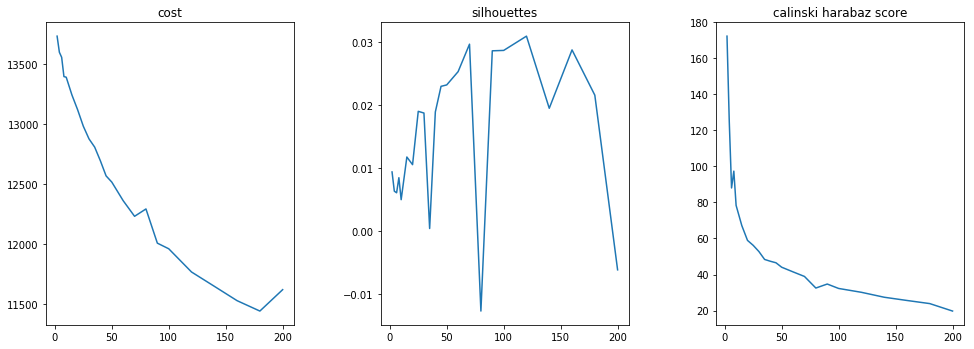

In [12]:
# Run again in transformed data
models, labels, costs, sil_avgs, ch_scores = runKmeansForMultipleCentroids(transformed_data)

In [16]:
# Chosen number of centroids
chosen_i = 18 # Meaning 120 centroids.
chosen_model = models[chosen_i]
chosen_model_labels = labels[chosen_i]
print('Chosen # of centroids: {}'.format(chosen_model.n_clusters))
print('Cost:                    %18.3f' % costs[chosen_i])
print('Silhouette avg:          %18.3f' % sil_avgs[chosen_i])
print('Calinski-Harabasz Index: %18.3f' % ch_scores[chosen_i])
analyze_centroids(chosen_model, chosen_model_labels, transformed_data)

Chosen # of centroids: 120
Cost:                             11766.206
Silhouette avg:                       0.031
Calinski-Harabasz Index:             30.119
Selected groups: [83 56 59 29 80]


<table><tr><th>Medoid</th><th>Closest 1</th><th>Closest 2</th></tr><tr></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**52fbb14cf1a9e862ec74d7695a8e6bdd85546efb**<br>Newsgroups: comp.graphics<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!uunet!zaphod.mps.ohio-state.edu!uwm.edu!cs.utexas.edu!utnut!torn!blaze.trentu.ca!trentu.ca!ccgwt<br>From: ccgwt@trentu.ca (Grant Totten)<br>Subject: MS-Windows graphics viewer?<br>Message-ID: &lt;1993Apr17.210333.23527@trentu.ca&gt;<br>Keywords: ms windows jpeg gif tiff <br>Lines: 31<br>Sender: news@trentu.ca (USENET News System)<br>Reply-To: ccgwt@trentu.ca (Grant Totten)<br>Organization: Trent University<br>Date: Sat, 17 Apr 1993 21:03:33 GMT<br><br><br>Howdy all,<br><br>	I was wondering if people could e-mail me their opinions on<br>the various graphics viewers available for MS-Windows 3.x...  I'm<br>working on a project to set up our scanner and write documentation on<br>how to use it and it would be nice to have a snazzy image viewer <br>to look at (and maybe even edit?) the image you just scanned.<br><br>The file formats I'm looking for:<br><br>GIF<br>JPEG<br>TIFF<br>PCX<br>whatever other 'major' file formats there are.<br><br>Thanks a lot for your help<br><br>Grant<br><br>--<br>Grant Totten, Programmer/Analyst, Trent University, Peterborough Ontario<br>GTotten@TrentU.CA            Phone: (705) 748-1653   FAX: (705) 748-1246<br>========================================================================<br>In the days of old,<br>When Knights were bold,<br>	And women were too cautious;<br>Oh, those gallant days,<br>When women were women,<br>	And men were really obnoxious ...<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**ed96cbbd1b1e9ee04aed33c5f9c45d6b3e7888f2**<br>Newsgroups: rec.sport.hockey<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!spool.mu.edu!torn!utnut!alchemy.chem.utoronto.ca!golchowy<br>From: golchowy@alchemy.chem.utoronto.ca (Gerald Olchowy)<br>Subject: Re: Flames Truly Brutal in Loss<br>Message-ID: &lt;1993Apr19.051636.21189@alchemy.chem.utoronto.ca&gt;<br>Organization: University of Toronto Chemistry Department<br>References: &lt;vzhivov.735193129@cunews&gt;<br>Date: Mon, 19 Apr 1993 05:16:36 GMT<br>Lines: 11<br><br>In article &lt;vzhivov.735193129@cunews&gt; vzhivov@superior.carleton.ca (Vladimir Zhivov) writes:<br>&gt;As the subject suggests the Flames were not impressive this afternoon,<br>&gt;dropping a 6-3 decision to the LA Kings. Most of the Flames neglected<br>&gt;to show up, especially in their own zone, as the Kings hit at least<br>&gt;five posts! The Flames best line was probably<br><br>Mike Vernon is now 3 wins 11 losses plus that All-Star game debacle in<br>afternoon games during his career...with another afternoon game with<br>Los Angeles next Sunday...has the ABC deal doomed the Flames?<br><br>Gerald<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**bb26f0e98b990d4eb371d398b90a004794ee994a**<br>Newsgroups: rec.sport.hockey<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!zaphod.mps.ohio-state.edu!uwm.edu!cs.utexas.edu!utnut!torn!watserv2.uwaterloo.ca!watmath!undergrad.math.uwaterloo.ca!rhirji<br>From: rhirji@undergrad.math.uwaterloo.ca (Rahim Hirji)<br>Subject: Re: Flames Question<br>Message-ID: &lt;C5LKDE.2HF@undergrad.math.uwaterloo.ca&gt;<br>Keywords: Roberts Flames<br>Sender: news@undergrad.math.uwaterloo.ca<br>Organization: University of Waterloo<br>References: &lt;C5HtrB.ICE@ccu.umanitoba.ca&gt;<br>Date: Fri, 16 Apr 1993 22:12:48 GMT<br>Lines: 22<br><br>In article &lt;C5HtrB.ICE@ccu.umanitoba.ca&gt; clhawth@ccu.umanitoba.ca (Timothy Chesley) writes:<br>&gt;I heard a little while back that Gary Roberts would be returning to play<br>&gt;in Calgary's last regular season game.  Can anybody confirm this??<br>&gt;He'll be a big help to the Flames in the playoffs and may change my<br>&gt;playoff pool strategy.<br><br><br>Roberts played in last night game against the Sharks and got a goal (38th)<br>and an assist.<br><br>This definitely bolsters Calgary's chances in the playoffs.<br><br><br>							Rahim Hirji<br><br><br> <br>-- <br>				     |  Rahim Hirji<br> Life is what happens while you are  |  Actuarial Science<br> making other plans		     |  rhirji@descartes.uwaterloo.ca<br>				     |  University of Waterloo<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**98c26b3a5e0b0efa4082d875e1617ef72690e52d**<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!swrinde!cs.utexas.edu!utnut!utzoo!censor!isgtec!robert<br>From: robert@isgtec.com (Robert Osborne)<br>Newsgroups: can.politics,talk.politics.guns<br>Subject: Waco<br>Message-ID: &lt;4625@isgtec.isgtec.com&gt;<br>Date: 23 Apr 93 15:23:03 GMT<br>References: &lt;1993Apr21.213400.15908@ve6mgs.ampr.org&gt;<br>Sender: news@isgtec.com<br>Distribution: na<br>Lines: 77<br>X-Newsreader: TIN [version 1.1 PL9]<br><br>Cross-posted to talk.politics.guns from can.politics:<br><br>Mark G. Salyzyn (mark@ve6mgs.ampr.org) wrote:<br># cmk@world.std.com (Charles M Kozierok) writes:<br># &gt;been to Waco, Texas lately? yes, the government takes care of us<br># &gt;all, doesn't it? as long as you belong to a government-sanctioned<br># &gt;religion.<br>#<br># Excuse me, but didn't these gun-ladden cult members threaten, shoot and kill<br># some people?<br><br>They threatened no one.  Their neighbours thought they were a little<br>strange but all in all the kind of people you would want to live<br>next door to.<br><br>One version has the BATF serving a search warrant by jumping out<br>of a horse trailer with guns and tossing concussion grenades.  If<br>this is the true order of events then the 'cult' could not know<br>that a search warrant was being served and since there was no proof<br>that these guys were police,  the 'cult' had every right to defend<br>themselves.<br><br>: Torching themselves shows briliant tactics, and convinces me<br>: they realy belong in society ...<br><br>If you watch actual footage of the fire from start to finish it<br>is not at all clear that fire wasn't started by the tanks.  The<br>people who survived are claiming that the fire was started by<br>the tanks knocking over some kerosene lanterns.  The FBI is<br>claiming that the 'cult' started the fire.<br><br>'they realy belong in society' is a catchy phrase but<br>I'm personally waiting to see what the Texas Rangers have to say<br>about it all before I pass judgment.   Why don't you do the same.<br><br>Some more interesting facts about the Waco incident:<br><br>1)  The original assault was conducted by BATF officers wearing<br>    an assorted types of camouflage.  I saw, on CNN, at least<br>    three different types.   I would be hard pressed to identify<br>    a bunch of guys in 'bring-your-own' battle fatigues as<br>    uniformed officers of the law even if they were claiming to<br>    be police.<br>    <br>2)  The BATF has been lying from the beginning:<br>    + "We only had handguns" - the original footage showed 4 BATF<br>      officers on a roof top getting shot at,  one had an MP-5<br>      assault sub-machine gun.<br>    + "We were out gunned" - sub-machine guns and shotguns are the<br>      BEST in quarters weapon,  you can't be out gunned when you<br>      have the best guns available for the job.<br>    + "We didn't know they had guns that would shoot through doors!" -<br>      this one is the best,  there are very few guns that won't shoot<br>      through a household door,  or through a house WALL for that<br>      matter.  Since officers from the Bureau of Alcohol, Tobacco, and<br>      Firearms should know that,  they are either lying or incredibly<br>      incompetent.  Not to mention criminally negligent if they are<br>      shooting bullets that they think will stop when the encounter<br>      plywood.<br>    + "We had a search warrant.  Actually, we had an arrest warrant.<br>       No, wait,  we had both.  Yeah, that's the ticket.<br>       Oh, and they're child molesters too.  And they make drugs.<br>       Did we mention we think they have rocket launchers."<br>      - The story from BATF and FBI spokespeople has changed daily<br>      and their claims were getting increasingly outrageous.<br>      <br>3)  Throughout the siege the FBI and BATF have be claiming that one<br>    of their biggest concerns was that Koresh and his followers would<br>    mass suicide.   Now they are claiming that that's what he did<br>    AND that they are surprised that he did.  Huh?<br><br>All in all I think that anything the FBI and BATF say should be<br>taken with a grain or two of salt.<br><br>Rob.<br>--<br>Robert A. Osborne   ...!uunet.ca!isgtec!robert or robert@isgtec.com<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**00b678a7cc8bda6a9f934391c9e8a24c2488fe6f**<br>Newsgroups: talk.politics.guns<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!agate!headwall.Stanford.EDU!Csli!cower<br>From: cower@csli.stanford.edu (Richard Cower)<br>Subject: Waco dates - are these coincidental?<br>Message-ID: &lt;1993Apr5.184700.28601@Csli.Stanford.EDU&gt;<br>Sender: cower@Csli.Stanford.EDU (Richard Cower)<br>Organization: CSLI, Stanford University<br>Distribution: usa<br>Date: Mon, 5 Apr 1993 18:47:00 GMT<br>Lines: 34<br><br><br>The ATF agent interviewed on "Street Stories" reported that the raid was<br>ill planned, and went ahead even when they (the BD's) knew the ATF was <br>coming. WHY?<br><br>I believe this raid was ill planned because they only had 2 days to plan it,<br>and it was continued when failure was obvious because it had a bit part<br>in the much larger political agenda of President Clinton. I would even <br>suggest that the loss of 4 ATF agents is inconsequential in this the<br>context of his political agenda. It MIGHT even be beneficial to his agenda, <br>as it helps point up just how evil these assualt weapons are. Further proof<br>might be that the ATF denied their agents (Street Stories report) requests<br>for sufficient fire power. <br><br>Important dates: <br>Feb 25th - NJ assembly votes to overturn assault weapon ban.<br>Feb 28th - Compound in Waco attacked.	   <br><br>On Feb. 25th the New Jersey assembly voted to overturn the assault weapon<br>ban in that state. It looked like it might be a tight vote, but the Senate<br>in N.J. was going to vote to overturn the ban. It would not sit well to have<br>an Eastern state overturn an assault weapon ban, given Clintons stated<br>agenda on gun control. I suspect Clinton gave the order to get someone or some<br>group with assualt weapons and have the press present (they were initially<br>at the incident in Waco) to record the event for the TV audience. The agent <br>on "Street Stories" reported that a supervisor was urging them all to "get <br>ready fast", as "they know we are coming". I believe this attack continued, <br>even tho the probablility of failure was high,  because it came from the top <br>down. After the N.J. assembly vote, the ATF had a limited amount of time to<br>come up with something, and the Wackos in Waco fit the bill nicely.<br><br>...rich <br><br><br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**a4c715ecf83aadacfa76e0f9bce1321c0aa70198**<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!gatech!prism!gt6511a<br>From: gt6511a@prism.gatech.EDU (COCHRANE,JAMES SHAPLEIGH)<br>Newsgroups: talk.politics.guns<br>Subject: Re: The Truth about Waco<br>Message-ID: &lt;94616@hydra.gatech.EDU&gt;<br>Date: 24 Apr 93 20:06:11 GMT<br>References: &lt;25337@alice.att.com&gt; &lt;1ppv94-@dixie.com&gt; &lt;C6054E.BJq@chinet.chi.il.us&gt;<br>Distribution: usa<br>Organization: Georgia Institute of Technology<br>Lines: 41<br><br>OK... quick scenario... you're at home, not bothering anybody... next thing you<br>know, somebody comes crashing in the upstairs window and you hear an explosion.<br>You see that this individual has a submachinegun, and that more similarly armed<br>individuals are rushing your front door.  Will you a) defend yourself and family<br>against this attack b) realize "oh, only the BATF would enter like that, so I <br>better surrender" or c) roll over and let whoever is attacking your home do<br>what they would like?  You have chosen a), and discover that the people you <br>defended yourself against are federal agents, who now are camped outside your<br>door waiting for you to surrender.  You have learned that they intend to <br>charge you with murder, and are further defaming your name, while claiming that<br>you can safely surrender at any time.  Then they start using psychological <br>warfare techniques against you, while still claiming that you can safely give up<br>and will receive a fair trial.  Some weeks into this standoff, you are still<br>holding out, when they begin a new ploy to induce your surrender, namely using<br>tear gas to annoy you, and ramming your home with tanks.  Yet they claim that<br>you can safely surrender at any time.  While you patiently wait out this latest<br>round of attacks, your house catches fire and the bales of hay you were using as<br>cover spread the fire rapidly through the house, and you try to escape through<br>the fortifications you had raised for your own defense and the rubble created<br>by the tanks.  Only 9 of your followers make it.<br><br>I am not claiming that the above scenario is accurate.  I am disagreeing with<br>the notion that it is their own fault for dying because they refused to <br>surrender to agents of the Federal government after another federal agency<br>committed an armed assault of their home on the basis of a flimsily concocted<br>search warrant.  <br><br>Look at how the Texas Rangers view the BATF.  Look at the FBI statements<br>regarding the BATF actions.  From all apparent sources, the FBI blundered<br>trying to clean up the mess made by the BATF, resulting in an accidental fire<br>which killed most of the BD's who were still in the compound, and are now <br>playing CYA.  The BATF committed an illegal assault, obtained the use of <br>Texas NG resources with fabricated allegations, and compounded their abuses<br>by accusing the BD's of crimes outside their jurisdiction once they had been<br>held off in their assault.<br><br>-- <br><br>James S. Cochrane          When in danger, or in doubt, run in  This space <br>gt6511a@prism.gatech.edu   circles, scream and shout.           for rent<br><br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**3ecde7d7524fb34c4395a99723461be2ad550f61**<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!gatech!pitt.edu!pitt!geb<br>From: geb@cs.pitt.edu (Gordon Banks)<br>Newsgroups: sci.med<br>Subject: Re: compartment syndrome - general information, references, etc.<br>Keywords: compartment syndrome, blood clots<br>Message-ID: &lt;19441@pitt.UUCP&gt;<br>Date: 6 Apr 93 16:55:30 GMT<br>References: &lt;639@cfdd50.boeing.com&gt;<br>Sender: news@cs.pitt.edu<br>Reply-To: geb@cs.pitt.edu (Gordon Banks)<br>Organization: Univ. of Pittsburgh Computer Science<br>Lines: 20<br><br>In article &lt;639@cfdd50.boeing.com&gt; lry1219@cfdd50.boeing.com (Larry Yeagley) writes:<br>&gt;I have an acquaintance who has been diagnosed as having blood clots and<br>&gt;"compartment syndrome". I searched the latest edition of the Columbia medical<br>&gt;encyclopedia and found nothing. Mosby's medical dictionary gives a very brief<br>&gt;description which suggests it's an arterial condition. Can someone point me (an<br><br>Compartment syndrome occurs when swelling happens in a "compartment"<br>bounded by fascia.  The pressure rises in the compartment and blood<br>supply and nerves are compromised.  The treatment is to open the<br>compartment surgically.  THe most common places for compartment<br>syndromes are the forearm and calf.  It is an emergency, since<br>if the pressure is not relieved, stuff will die.<br><br><br><br>-- <br>----------------------------------------------------------------------------<br>Gordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and<br>geb@cadre.dsl.pitt.edu   |  it is shameful to surrender it too soon." <br>----------------------------------------------------------------------------<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**6bb839955541c1ae9094ed42f72077bf6494390e**<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!gatech!pitt.edu!pitt!geb<br>From: geb@cs.pitt.edu (Gordon Banks)<br>Newsgroups: sci.med<br>Subject: Re: Update (Help!) [was "What is This [Is it Lyme's?]"]<br>Message-ID: &lt;19394@pitt.UUCP&gt;<br>Date: 5 Apr 93 14:11:41 GMT<br>References: &lt;1ook0ns79@gw.home.vix.com&gt; &lt;1993Mar24.182145.11004@equator.com&gt;<br>Sender: news@cs.pitt.edu<br>Reply-To: geb@cs.pitt.edu (Gordon Banks)<br>Organization: Univ. of Pittsburgh Computer Science<br>Lines: 24<br><br>In article &lt;1993Mar24.182145.11004@equator.com&gt; jod@equator.com (John Setel O'Donnell) writes:<br><br>&gt;IMHO, you have Lyme disease. <br><br><br>&gt;I sent you in private email a summary of the treatment protocols put<br>&gt;forth by the Lyme Disease Foundation.  I respectfully suggest that you<br>&gt;save yourself a great deal of suffering by contacting them for a<br>&gt;Lyme-knowledgeable physician referral and seek treatment at once.<br>&gt;You'll know in 2 weeks if you're on the right course; and the clock is<br>&gt;ticking on your 6 weeks if you have it. 1-800-886-LYME.<br><br>If these folks are who I think they are, Lyme-knowledgeable may<br>mean a physician to whom everything that walks in the door is<br>lyme disease, and you will be treated for lyme, whether or not<br>you have it.  Hope you have good insurance.<br><br><br><br>-- <br>----------------------------------------------------------------------------<br>Gordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and<br>geb@cadre.dsl.pitt.edu   |  it is shameful to surrender it too soon." <br>----------------------------------------------------------------------------<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**943f3db784e81e4fffc9706d7336e0d9e3bb7924**<br>Xref: cantaloupe.srv.cs.cmu.edu misc.health.alternative:2293 sci.med:58922<br>Path: cantaloupe.srv.cs.cmu.edu!rochester!udel!gatech!pitt!geb<br>From: geb@cs.pitt.edu (Gordon Banks)<br>Newsgroups: misc.health.alternative,sci.med<br>Subject: Re: NIH offers "Exploratory Grants For Alternative Medicine"<br>Message-ID: &lt;19651@pitt.UUCP&gt;<br>Date: 18 Apr 93 00:47:05 GMT<br>References: &lt;kaminskiC4s9CH.JGJ@netcom.com&gt; &lt;19493@pitt.UUCP&gt; &lt;1993Apr9.172945.4578@island.COM&gt;<br>Sender: news@cs.pitt.edu<br>Reply-To: geb@cs.pitt.edu (Gordon Banks)<br>Followup-To: misc.health.alternative<br>Organization: Univ. of Pittsburgh Computer Science<br>Lines: 30<br><br>In article &lt;1993Apr9.172945.4578@island.COM&gt; green@island.COM (Robert Greenstein) writes:<br>&gt;In article &lt;19493@pitt.UUCP&gt; geb@cs.pitt.edu (Gordon Banks) writes:<br>&gt;&gt;One problem is very few scientists are interested in alternative medicine.<br>&gt;<br>&gt;So Gordon, why do you think this is so?<br>&gt;-- <br><br>Probably because most of them come packaged with some absurd theory<br>behind them.  E.G. homoeopathy: like cures like.  The more you dilute<br>things, the more powerful they get, even if you dilute them so much<br>there is no ingredient but water left.  Chiropractic: all illness<br>stems from compressions of nerves by misaligned vertebrae.  Such<br>systems are so patently absurd, that any good they do is accidental<br>and not related to the theory.  The only exception is probably herbalism,<br>because scientists recognize the potent drugs that derive from plants<br>and are always interested in seeing if they can find new plants<br>that have active and useful substances.  But that isn't what <br>is meant by alternative medicine, usually.  If you get into the Qi,<br>accupuntunce charts, etc, you are now back to silly theories that<br>probably have nothing to do with why accupuncture works in some cases.<br><br>Perhaps another reason they are reluctant is the Rhine experience.<br>Rhine was a scientist who wanted to investigate the paranormal<br>and his lab was filled with so much chacanery and fakery that <br>people don't want to be associated with that sort of thing.  <br>-- <br>----------------------------------------------------------------------------<br>Gordon Banks  N3JXP      | "Skepticism is the chastity of the intellect, and<br>geb@cadre.dsl.pitt.edu   |  it is shameful to surrender it too soon." <br>----------------------------------------------------------------------------<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**38a850df75ffa86fbd0f48d3998e5ec0d9b17730**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.religion.misc:83763 talk.politics.misc:178815 sci.skeptic:43435<br>Newsgroups: talk.religion.misc,talk.politics.misc,sci.skeptic<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!gatech!usenet.ufl.edu!cybernet!michaelb<br>From: michaelb@cse.fau.edu (Michael Rogero Brown)<br>Subject: Re: Who's next? Mormons and Jews?<br>Message-ID: &lt;1993Apr22.173807.7024@cybernet.cse.fau.edu&gt;<br>Sender: news@cybernet.cse.fau.edu<br>Organization: Florida Atlantic University, Boca Raton, FL, USA<br>References: &lt;93109.231733ISSCCK@BYUVM.BITNET&gt; &lt;F2cc3B2w164w@cellar.org&gt;<br>Date: Thu, 22 Apr 1993 17:38:07 GMT<br>Lines: 35<br><br>In article &lt;F2cc3B2w164w@cellar.org&gt; revpk@cellar.org (Brian 'Rev P-K' Siano) writes:<br>[stuff about mormons &amp; jews deleted]<br><br>&gt;And as an agnostic who's slightly aware of the Mormon Wars that Casper<br>&gt;describes, I'd side with him on this. Not that I support the Koreshians, nor<br>                                                              ^^^^^^^^^^<br>&gt;do I support the Mormons, but in a nasty sense, the major difference is<br>&gt;this; in 1857, the Mormons kicked the U.S. Army's ass. In 1993, the<br>&gt;Koreshians died in an inferno. Chances are, if things had turned out a<br> ^^^^^^^^^^<br>&gt;little differently, we might have Koreshians posting to the Net a hundred<br>                                   ^^^^^^^^^^<br>&gt;years from now talking about some future, analogous event.<br>&gt;<br>A little comment here:<br><br>Please DON't use the term "Koreshians" when referring to the Branch Davidians.<br>The term Koreshians is already being used.  It is the name of a now non-exist<br>'cult' formed in the early part of this centuary by a Cyrus Reed Teed who<br>renamed himself 'Koresh'.  He formed a religious group called the Koreshian<br>Unity which believed that the Earth was Hollow &amp; WE lived on the inside.  The<br>were formed in Chicago, but left to establish their 'New Jerusalem' in Estero<br>Florida.  The group was fairly successful, but soon died out as they believed<br>in celebacy.  The last member died about 5-10 years ago.<br><br>The Koreshian were a pretty intersting group.  Today their community is now<br>a Florida State Historical Site.  A local historical group sponsors two <br>festivals every year their which coinsides with the cult's two festivals.<br><br><br>-- <br>&lt;&lt; Michael Rogero Brown                      | Any opinions expressed are my  &gt;&gt;<br>&lt;&lt; CS Graduate Student-Florida Atlantic Univ |  own, and generally unpopular  &gt;&gt;<br>&lt;&lt; Internet: michaelb@sol.cse.fau.edu        |  with others.                  &gt;&gt;<br>&lt;&lt; BitNet: m_brown@fauvax                    | Ask me if I care.              &gt;&gt;<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**38a850df75ffa86fbd0f48d3998e5ec0d9b17730**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.religion.misc:83763 talk.politics.misc:178815 sci.skeptic:43435<br>Newsgroups: talk.religion.misc,talk.politics.misc,sci.skeptic<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!howland.reston.ans.net!gatech!usenet.ufl.edu!cybernet!michaelb<br>From: michaelb@cse.fau.edu (Michael Rogero Brown)<br>Subject: Re: Who's next? Mormons and Jews?<br>Message-ID: &lt;1993Apr22.173807.7024@cybernet.cse.fau.edu&gt;<br>Sender: news@cybernet.cse.fau.edu<br>Organization: Florida Atlantic University, Boca Raton, FL, USA<br>References: &lt;93109.231733ISSCCK@BYUVM.BITNET&gt; &lt;F2cc3B2w164w@cellar.org&gt;<br>Date: Thu, 22 Apr 1993 17:38:07 GMT<br>Lines: 35<br><br>In article &lt;F2cc3B2w164w@cellar.org&gt; revpk@cellar.org (Brian 'Rev P-K' Siano) writes:<br>[stuff about mormons &amp; jews deleted]<br><br>&gt;And as an agnostic who's slightly aware of the Mormon Wars that Casper<br>&gt;describes, I'd side with him on this. Not that I support the Koreshians, nor<br>                                                              ^^^^^^^^^^<br>&gt;do I support the Mormons, but in a nasty sense, the major difference is<br>&gt;this; in 1857, the Mormons kicked the U.S. Army's ass. In 1993, the<br>&gt;Koreshians died in an inferno. Chances are, if things had turned out a<br> ^^^^^^^^^^<br>&gt;little differently, we might have Koreshians posting to the Net a hundred<br>                                   ^^^^^^^^^^<br>&gt;years from now talking about some future, analogous event.<br>&gt;<br>A little comment here:<br><br>Please DON't use the term "Koreshians" when referring to the Branch Davidians.<br>The term Koreshians is already being used.  It is the name of a now non-exist<br>'cult' formed in the early part of this centuary by a Cyrus Reed Teed who<br>renamed himself 'Koresh'.  He formed a religious group called the Koreshian<br>Unity which believed that the Earth was Hollow &amp; WE lived on the inside.  The<br>were formed in Chicago, but left to establish their 'New Jerusalem' in Estero<br>Florida.  The group was fairly successful, but soon died out as they believed<br>in celebacy.  The last member died about 5-10 years ago.<br><br>The Koreshian were a pretty intersting group.  Today their community is now<br>a Florida State Historical Site.  A local historical group sponsors two <br>festivals every year their which coinsides with the cult's two festivals.<br><br><br>-- <br>&lt;&lt; Michael Rogero Brown                      | Any opinions expressed are my  &gt;&gt;<br>&lt;&lt; CS Graduate Student-Florida Atlantic Univ |  own, and generally unpopular  &gt;&gt;<br>&lt;&lt; Internet: michaelb@sol.cse.fau.edu        |  with others.                  &gt;&gt;<br>&lt;&lt; BitNet: m_brown@fauvax                    | Ask me if I care.              &gt;&gt;<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**ba9507054fb82996406fee2b0529cbc674c3041a**<br>Xref: cantaloupe.srv.cs.cmu.edu talk.religion.misc:83696 talk.politics.misc:178685 sci.skeptic:43324<br>Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!pitt.edu!dsinc!gvls1!tredysvr!cellar!revpk<br>From: revpk@cellar.org (Brian 'Rev P-K' Siano)<br>Newsgroups: talk.religion.misc,talk.politics.misc,sci.skeptic<br>Subject: Re: Who's next? Mormons and Jews?<br>Message-ID: &lt;F2cc3B2w164w@cellar.org&gt;<br>Date: 21 Apr 93 05:28:02 GMT<br>References: &lt;93109.231733ISSCCK@BYUVM.BITNET&gt;<br>Sender: bbs@cellar.org (The Cellar BBS)<br>Organization: The Cellar BBS and public access system<br>Lines: 35<br><br>ISSCCK@BYUVM.BITNET (Casper C. Knies) writes:<br><br>&gt; <br>&gt; Gedaliah Friedenberg (friedenb@maple.egr.msu.edu) writes:<br>&gt; <br>&gt; #In article &lt;1qvfik6rf@usenet.INS.CWRU.Edu&gt;, cj195@cleveland.Freenet.Edu<br>&gt; #(John W. Redelfs) writes:<br>&gt; #|&gt;<br>&gt; #|&gt; Now that Big Brother has rubbed out one minority religion in Waco, who<br>&gt; #|&gt; is next?  The Mormons or Jews?<br>&gt; #<br>&gt; #Give me a break.  If the Mormons fortified Utah and armed it to the teeth,<br>&gt; #and were involved in illegal activity, then they deserve whatever they get.<br>&gt; #                     ^^^^^^^^^^^^^^^^            ^^^^^^^<br>&gt; #You are making a ludicrous suggestion.<br>&gt; <br>&gt; As a Latter-day Saint, I found John's statement not at all ludicrous...<br><br>And as an agnostic who's slightly aware of the Mormon Wars that Casper<br>describes, I'd side with him on this. Not that I support the Koreshians, nor<br>do I support the Mormons, but in a nasty sense, the major difference is<br>this; in 1857, the Mormons kicked the U.S. Army's ass. In 1993, the<br>Koreshians died in an inferno. Chances are, if things had turned out a<br>little differently, we might have Koreshians posting to the Net a hundred<br>years from now talking about some future, analogous event.<br><br><br>Brian "Rev. P-K" Siano                                  revpk@cellar.org<br><br>"Well, I'll know right away by the look in her eyes<br>she's lost all illusions and she's worldly wise, and I know<br>if I give her a listen, she's what I've been missing, what I've been missing<br>I'll be lost in love and havin' some fun with my cynical girl<br>Who's got no use for the real world, I'm looking for a Cynical Girl"<br>          --- Marshall Crenshaw, "Cynical Girl"<br></td></tr><tr><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**e7d729d93be8b5350a8ee627c3bf8c21f3d279a1**<br>Xref: cantaloupe.srv.cs.cmu.edu rec.backcountry:30908 talk.politics.guns:54227<br>Newsgroups: rec.backcountry,talk.politics.guns<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!headwall.Stanford.EDU!CSD-NewsHost.Stanford.EDU!SAIL.Stanford.EDU!andy<br>From: andy@SAIL.Stanford.EDU (Andy Freeman)<br>Subject: Re: Insane Gun-toting Wackos Unite!!!<br>Message-ID: &lt;1993Apr15.195910.28806@CSD-NewsHost.Stanford.EDU&gt;<br>Followup-To: talk.politics.guns<br>Sender: news@CSD-NewsHost.Stanford.EDU<br>Organization: Computer Science Department,  Stanford University.<br>References: &lt;13633@sail.LABS.TEK.COM&gt; &lt;1576@heimdall.sdrc.com&gt;<br>Distribution: na<br>Date: Thu, 15 Apr 1993 19:59:10 GMT<br>Lines: 38<br><br>In article &lt;1576@heimdall.sdrc.com&gt; crrob@sony1.sdrc.com (Rob Davis) writes:<br>&gt; Do you know how many deaths each year are caused by self-inflicted gun-<br>&gt; shot wounds by people wearing thigh holsters?<br><br>No, but I have several other breakdowns of accidental shootings.<br>I've never seen one that specifically provides the info that Davis insists<br>that he has, so I'd love to have a cite.<br><br>&gt;If you fall, for example,<br>&gt; and land on the handgun or cause a sudden blow, the gun will discharge.<br><br>Wrong.  There's one gun design where that can happen, and it is<br>supposed to be carried with the hammer over an unloaded chamber.<br>(Cocking the gun turns the cylinder so that a loaded cylinder is under<br>the hammer.  In other words, it can be usefully carried in a safe<br>manner.)  Other handgun designs don't have that property; if their<br>trigger isn't pulled, the hammer can't hit the firing pin.<br><br>&gt; The number of people killed in this manner far outweighs the number of<br>&gt; deaths caused by animal attacks or "wacko" attacks combined.<br><br>The breakdowns that I do have include the above category.  From them I<br>can safely say that if Davis is right in ALL of his claims, a large<br>negative number of people are killed by animals, because we know that<br>the number of killings by wackos is reasonably large and that the<br>number of accidents due to gun failures (which is a superset of the<br>described circumstance) is near zero.<br><br>&gt;I can find the figures if you don't believe me.<br><br>Please do.  Include a cite for those of us who like looking at<br>context.  Make sure that your source excludes other types of<br>accidents and suicides that are misreported.  ("Gun cleaning<br>accident" is police-speak for "the family needs the insurance<br>money.")<br><br>-andy<br>--<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**71d96e7243b38b08d7bc52164285e73c61317677**<br>Newsgroups: rec.motorcycles,ba.motorcycles<br>Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!agate!headwall.Stanford.EDU!CSD-NewsHost.Stanford.EDU!Xenon.Stanford.EDU!robert<br>From: robert@Xenon.Stanford.EDU (Robert Kennedy)<br>Subject: Battery storage -- why not charge and store dry?<br>Message-ID: &lt;1993Apr16.060459.8632@CSD-NewsHost.Stanford.EDU&gt;<br>Sender: news@CSD-NewsHost.Stanford.EDU<br>Organization: Computer Science Department, Stanford University.<br>Date: Fri, 16 Apr 1993 06:04:59 GMT<br>Lines: 24<br><br>So it looks like I'm going to have to put a couple of bikes in storage<br>for a few months, starting several months from now, and I'm already<br>contemplating how to do it so they're as easy to get going again as<br>possible. I have everything under control, I think, besides the<br>batteries. I know that if I buy a 50.00 Battery Tender for each one<br>and leave them plugged in the whole time the bikes are in storage,<br>they'll be fine. But I'm not sure that's necessary. I've never heard<br>anyone discussing this idea, so maybe there's some reason why it isn't<br>so great. But maybe someone can tell me.<br><br>Would it be a mistake to fully charge the batteries, drain the<br>electrolyte into separate containers (one for each battery), seal the<br>container, close up the batteries, and leave them that way? Then it<br>would seem that when the bikes come out of storage, I could put the<br>electrolyte back in the batteries and they should still be fully<br>charged. What's wrong with this?<br><br>On a related, but different note for you Bay Area Denizens, wasn't<br>there someone who had a bunch of spare EDTA a few months back? Who was<br>it? Is there still any of it left?<br><br>Thanks for any and all help!<br><br>	-- Robert<br></td><td style="text-align: left;vertical-align: top; width: 300px; word-break:break-all;">**53245fed68c2b06f7433e48fdf7246c87bb0ebe2**<br>Xref: cantaloupe.srv.cs.cmu.edu rec.backcountry:31152 talk.politics.guns:54733<br>Newsgroups: rec.backcountry,talk.politics.guns<br>Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!noc.near.net!howland.reston.ans.net!agate!headwall.Stanford.EDU!CSD-NewsHost.Stanford.EDU!SAIL.Stanford.EDU!andy<br>From: andy@SAIL.Stanford.EDU (Andy Freeman)<br>Subject: Re: guns in backcountry? no thanks<br>Message-ID: &lt;1993Apr16.211654.16926@CSD-NewsHost.Stanford.EDU&gt;<br>Followup-To: talk.politics.guns<br>Sender: news@CSD-NewsHost.Stanford.EDU<br>Organization: Computer Science Department,  Stanford University.<br>References: &lt;1qkcoks9i@usenet.INS.CWRU.Edu&gt;<br>Date: Fri, 16 Apr 1993 21:16:54 GMT<br>Lines: 25<br><br>In article &lt;1qkcoks9i@usenet.INS.CWRU.Edu&gt; ci946@cleveland.Freenet.Edu (John K. Gever) writes:<br>&gt;Public health experts will tell you that you are far more likely<br>&gt;have your gun stolen, use it yourself on a family member or<br>&gt;have it used on you than you are to use it on an actual criminal.<br><br>Actually, they won't.  What they'll tell you is that if you add up the<br>number of suicides, murders of one drug dealer by another, legit<br>self-defenses of a battered spouse, and so on, you'll end up with a<br>number that is much larger than the number of self-defense killings<br>against strangers committed in the bedroom.  (BTW - they didn't<br>honestly count the latter either, but let's not quibble.)  They<br>try to claim that comparison is between the costs of self-defense<br>and the benefits, but they're wrong.<br><br>This comparison doesn't measure the costs of self-defense and it<br>doesn't measure the benefits either.  For example, the goal is not to<br>kill the attacker, whatever your relationship to him, but to stop him.<br>While the number of killings may be proportional to the number of<br>stops, it isn't equal.<br><br>Anyone who confuses that comparison with an honest evaluation<br>is either lying or....<br><br>-andy<br>--<br></td></tr><tr></tr></table>

In [17]:
## Trying a more agressive dimensionality reduction

# Selecting the best number of components.
n_components = 250
print("Selected n_components: {}".format(n_components))

# Transforming the data.
pca = PCA(n_components)
transformed_data = pca.fit_transform(data)
print("New transformed data shape: {}".format(transformed_data.shape))
print("Accumulated variance: {}".format(round(sum(pca.explained_variance_ratio_) * 100)))

Selected n_components: 250
New transformed data shape: (19924, 250)
Accumulated variance: 31.0


2 clusters: Cost 5964.21; Silhouette avg 0.02234; Calinski-Harabasz Index: 403.86
4 clusters: Cost 5829.81; Silhouette avg 0.00456; Calinski-Harabasz Index: 294.34
6 clusters: Cost 5760.15; Silhouette avg 0.01525; Calinski-Harabasz Index: 229.15
8 clusters: Cost 5680.82; Silhouette avg 0.01112; Calinski-Harabasz Index: 206.38
10 clusters: Cost 5641.93; Silhouette avg 0.01343; Calinski-Harabasz Index: 179.23
15 clusters: Cost 5484.16; Silhouette avg 0.00315; Calinski-Harabasz Index: 158.43
20 clusters: Cost 5366.11; Silhouette avg -0.00150; Calinski-Harabasz Index: 146.36
25 clusters: Cost 5250.59; Silhouette avg 0.01900; Calinski-Harabasz Index: 136.93
30 clusters: Cost 5044.79; Silhouette avg 0.04392; Calinski-Harabasz Index: 142.45
35 clusters: Cost 4975.28; Silhouette avg 0.04613; Calinski-Harabasz Index: 132.74
40 clusters: Cost 4871.21; Silhouette avg 0.03686; Calinski-Harabasz Index: 128.57
45 clusters: Cost 4800.90; Silhouette avg 0.04116; Calinski-Harabasz Index: 122.26
50 clus

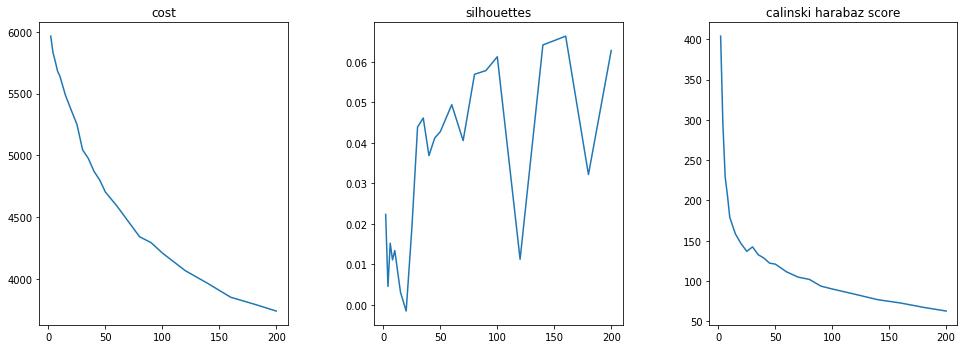

In [18]:
# Run again in transformed data
models, labels, costs, sil_avgs, ch_scores = runKmeansForMultipleCentroids(transformed_data)

In [19]:
# Chosen number of centroids for the agressive dimensionality reduction
chosen_i = 20 # Meaning 160 centroids.
chosen_model = models[chosen_i]
chosen_model_labels = labels[chosen_i]
print('Chosen # of centroids: {}'.format(chosen_model.n_clusters))
print('Cost:                    %18.3f' % costs[chosen_i])
print('Silhouette avg:          %18.3f' % sil_avgs[chosen_i])
print('Calinski-Harabasz Index: %18.3f' % ch_scores[chosen_i])
# analyze_centroids(chosen_model, chosen_model_labels, transformed_data)

# Performance metrics using original data
sil_avg = silhouette_score(data, chosen_model_labels)
ch_score = calinski_harabaz_score(data, chosen_model_labels)

print('Silhouette avg:          %18.3f' % sil_avg)
print('Calinski-Harabasz Index: %18.3f' % ch_score)


Chosen # of centroids: 160
Cost:                              3852.826
Silhouette avg:                       0.066
Calinski-Harabasz Index:             72.845
Silhouette avg:                       0.021
Calinski-Harabasz Index:             18.108


In [20]:
red_sil_avgs, sil_avgs = [], []
num_components = [750, 500, 300, 150, 130, 120, 110, 100, 90, 80, 70, 50, 25]
for n in num_components:
    pca = PCA(n)
    transformed_data = pca.fit_transform(data)
    #model = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=random_state)
    model = chosen_model # TEMP 
    
    myLabels, cost, red_sil_avg, ch_score = computeKMeansMetrics(model, transformed_data)
    red_sil_avgs.append(red_sil_avg)
    sil_avg = silhouette_score(data, myLabels)
    sil_avgs.append(sil_avg)
    ch_scores.append(ch_score)

    print("%4d components: acc variance: %5.1f, red_sil_avg: %6.4f, sil_avg: %6.4f" % (
            n, round(sum(pca.explained_variance_ratio_) * 100), red_sil_avg, sil_avg))

 750 components: acc variance:  59.0, red_sil_avg: 0.0294, sil_avg: 0.0174
 500 components: acc variance:  46.0, red_sil_avg: 0.0270, sil_avg: 0.0180
 300 components: acc variance:  34.0, red_sil_avg: 0.0529, sil_avg: 0.0203
 150 components: acc variance:  23.0, red_sil_avg: 0.0859, sil_avg: 0.0221
 130 components: acc variance:  21.0, red_sil_avg: 0.0814, sil_avg: 0.0174
 120 components: acc variance:  21.0, red_sil_avg: 0.0783, sil_avg: 0.0166
 110 components: acc variance:  20.0, red_sil_avg: 0.0862, sil_avg: 0.0195
 100 components: acc variance:  19.0, red_sil_avg: 0.0843, sil_avg: 0.0148
  90 components: acc variance:  17.0, red_sil_avg: 0.0852, sil_avg: 0.0135
  80 components: acc variance:  16.0, red_sil_avg: 0.0798, sil_avg: 0.0126
  70 components: acc variance:  15.0, red_sil_avg: 0.0830, sil_avg: 0.0130
  50 components: acc variance:  12.0, red_sil_avg: 0.0780, sil_avg: 0.0043
  25 components: acc variance:   8.0, red_sil_avg: 0.0862, sil_avg: -0.0017


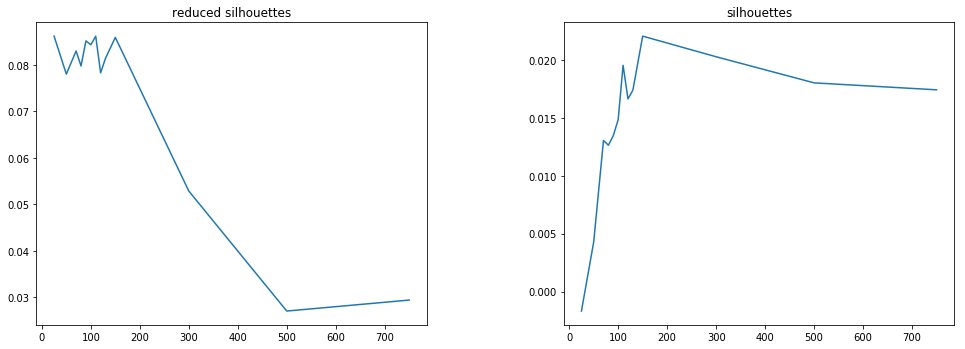

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex='col')

ax1.set_title('reduced silhouettes')
ax1.plot(num_components, red_sil_avgs)

ax2.set_title('silhouettes')
ax2.plot(num_components, sil_avgs)

f.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
f.set_size_inches(15, 5)
f.show()